In [1]:
import openmc

In [2]:
# c	LaBr detector
# c ****************************************
# m7       35079    -0.2946	$ Br79
# 	 35081	  -0.3069       $ Br81
#   	 57139    -0.3485	$ La139
# 	 58140    -0.0500 	$ Ce140
LaBr_detector_mat = openmc.Material(name='LaBr_detector')
LaBr_detector_mat.add_nuclide('Br79', 0.2946, 'wo')
LaBr_detector_mat.add_nuclide('Br81', 0.3069, 'wo')
LaBr_detector_mat.add_nuclide('La139', 0.3485, 'wo')
LaBr_detector_mat.add_nuclide('Ce140', 0.0500, 'wo')
LaBr_detector_mat.set_density('atom/b-cm', 5.08)

# c  **********************************
# m5	82207 1 $Lead
lead_mat = openmc.Material(name='lead')
lead_mat.add_nuclide('Pb207', 1)
lead_mat.set_density('atom/b-cm', 11.29)

# c ************ air den=1.15e-3g/cc********
# m12     8016 -0.23
#         7014 -0.77
air_mat = openmc.Material(name='air')
air_mat.add_nuclide('O16', 0.23, 'wo')
air_mat.add_nuclide('N14', 0.77, 'wo')
air_mat.set_density('g/cm3', 0.00129)



In [3]:
# m2000 6000 -0.15 14000 -0.374 8016 -0.4675 1001 -0.0085 
soil_mat = openmc.Material(name='soil')
soil_mat.add_nuclide('C6', 0.15, 'wo')
soil_mat.add_nuclide('Si14', 0.374, 'wo')
soil_mat.add_nuclide('O16', 0.4675, 'wo')
soil_mat.add_nuclide('H1', 0.0085, 'wo')
soil_mat.set_density('g/cm3', 1.6)

In [4]:
# export materials to xml
mats = openmc.Materials([LaBr_detector_mat, lead_mat, air_mat, soil_mat])
mats.export_to_xml()

In [5]:
def xrcc(y0, z0, x0, r, h):
    tube = openmc.XCylinder(y0=y0, z0=z0, r=r)
    bottom = openmc.XPlane(x0=x0)
    top = openmc.XPlane(x0=x0+h)
    return -tube & +bottom & -top

# make a class that can be used as geometry

In [6]:
def rpp(x0, y0, z0, x1, y1, z1):
    return +openmc.XPlane(x0=x0) & -openmc.XPlane(x0=x1) & +openmc.YPlane(y0=y0) & -openmc.YPlane(y0=y1) & +openmc.ZPlane(z0=z0) & -openmc.ZPlane(z0=z1)



In [37]:
# c SURFACE CARDS
# c
# c %%%%%%%%%%%
# c Sample Volume
# c %%%%%%%%%%%
# 1 rpp -500 500 -500 500 48 348 $Soil xmin xmax ymin ymax zmin zmax
# c %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# c Active Detector Region
# c %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 21 rcc -10.2  45.5 20.3   20.3 0.0 0.0   4.5 $Detector 1 Base center, Hx,Hy,Hz, radius 
# 22 rcc -10.2 -45.5 20.3   20.3 0.0 0.0   4.5 $Detector 2
# c %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# c Shielding Pb
# c %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 31 rpp -20.3 20.3 7.6 33 2.54 15.2 $Pb xmin xmax ymin ymax zmin zmax
# 32 rpp -20.3 20.3 -33 -7.6 2.54 15.2 $Pb xmin xmax ymin ymax zmin zmax
# c ************************
# 200 so 1500

# detector1 = gen.cylinder(21, pos = (-10.2, 45.5, 20.3), dir = (1, 0, 0), r=4.5, height=20.3)
# detector2 = gen.cylinder(22, pos = (-10.2, -45.5, 20.3), dir = (1, 0, 0), r=4.5, height=20.3)
# sheilding1 = gen.rpp(31, min = (-20.3, 7.6, 2.54), max = (20.3, 33, 15.2))
# sheilding2 = gen.rpp(32, min = (-20.3, -33, 2.54), max = (20.3, -7.6, 15.2))
# world = gen.sphere(200, pos = (0, 0, 0), r = 1500)

soil_surface = rpp(x0=-500, x1=500, y0=-500, y1=500, z0=48, z1=348)
det_surface_1 = xrcc(x0=-10, y0=45.5, z0=20.3, r=4.5, h=20.3)
det_surface_2 = xrcc(x0=-10, y0=-45.5, z0=20.3, r=4.5, h=20.3)
shielding_surface_1 = rpp(x0=-20.3, x1=20.3, y0=7.6, y1=33, z0=2.54, z1=15.2)
shielding_surface_2 = rpp(x0=-20.3, x1=20.3, y0=-33, y1=-7.6, z0=2.54, z1=15.2)
world_surface = -openmc.Sphere(r=1500) & ~soil_surface & ~det_surface_1 & ~det_surface_2 & ~shielding_surface_1 & ~shielding_surface_2

In [38]:
# c @@@@@@@@@@ Detectors @@@@@@@@@@@@@@@@@
# c
# 101 7 -5.08 -21 imp:n,p 1 $LaBr Detector #1 Active Region
# 102 7 -5.08 -22 imp:n,p 1 $LaBr Detector #2 Active Region
# c
# c @@@@@@@@@ Shielding @@@@@@@@@@@@@@@@@
# c
# 121 5 -11.29 -31 imp:n,p 1 $Pb1
# 122 5 -11.29 -32 imp:n,p 1 $Pb2
# c
# c @@@@@@@@@@ SOIL VOLUME @@@@@@@@@@@
# c
# 20 1 -1.542 -1 imp:n,p 1 $ SOIL VOLUME
# c
# 30 12 -0.00129 -200 #101 #102 #121 #122 #20    imp:n,p 1 $Rest of the World
# 31 0 200 imp:n,p 0 $Outside world
outside = openmc.Cell(fill=air_mat, region=world_surface, name='outside')
detector_1 = openmc.Cell(fill=LaBr_detector_mat, region=det_surface_1, name='detector_1')
detector_2 = openmc.Cell(fill=LaBr_detector_mat, region=det_surface_2, name='detector_2')
shielding_1 = openmc.Cell(fill=lead_mat, region=shielding_surface_1, name='shielding_1')
shielding_2 = openmc.Cell(fill=lead_mat, region=shielding_surface_2, name='shielding_2')
soil = openmc.Cell(fill=air_mat, region=soil_surface, name='soil')
root = openmc.Universe(cells=[
    # outside, 
    detector_1, detector_2, shielding_1, shielding_2, soil])
geom = openmc.Geometry(root)
geom.export_to_xml()



In [39]:
import matplotlib.pyplot as plt

[]

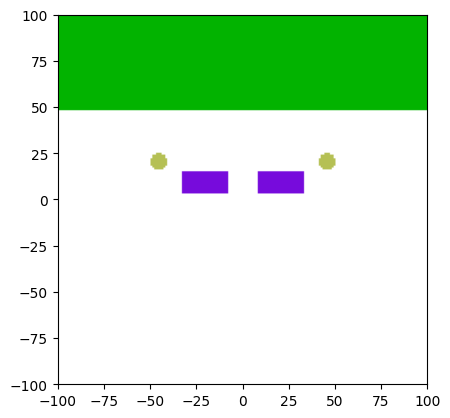

In [40]:

fig, ax = plt.subplots()
# ax.set_aspect('equal')
root.plot(width=(200.0, 200.0), origin=(0.0, 0.0, 0), basis='yz', color_by='material', axes=ax)
plt.plot()

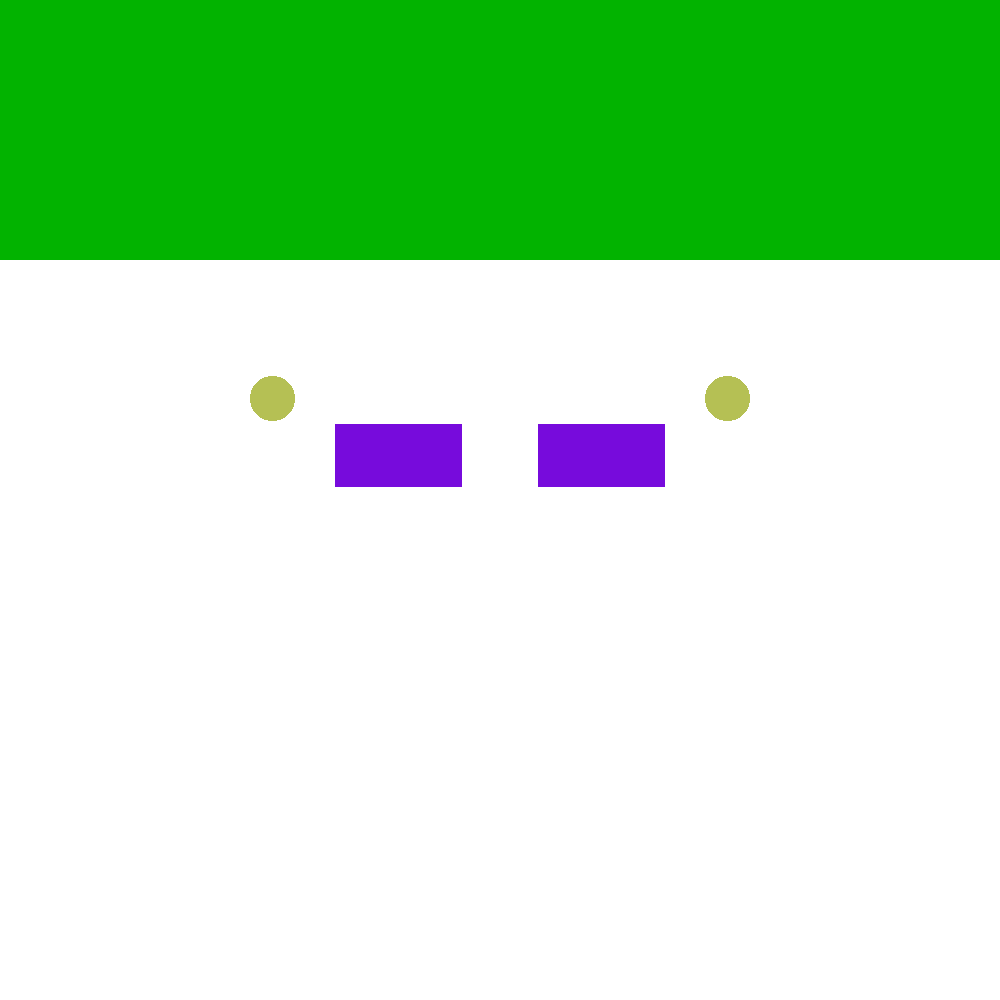

In [36]:
plot = openmc.Plot.from_geometry(geom, basis='yz')
plot.filename = 'plot'
plot.origin = (0, 0, 0)
plot.width = (200, 200)
plot.pixels = (1000, 1000)
plot.color_by = 'material'
openmc.plot_inline(plot)